###Importing of libraries

In [ ]:
#Importing of the libraries

import tensorflow.keras
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix,roc_auc_score,confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip "/content/drive/MyDrive/archive.zip" -d "/content/drive/MyDrive/Project/"

In [ ]:
training_directory = '/content/drive/MyDrive/Project/Training/'
training_paths = []
for label in os.listdir(training_directory):
    for file in os.listdir(training_directory+label):
        training_paths.append(training_directory + label+'/'+file)

random.shuffle(training_paths)

#One of the image path fro the training directory is being displayed
print(training_paths[0])

/content/drive/MyDrive/Project/Training/meningioma/Tr-me_1320.jpg


In [ ]:
testing_directory = '/content/drive/MyDrive/Project/Testing/'
testing_paths = []
for label in os.listdir(testing_directory):
    for file in os.listdir(testing_directory+label):
        testing_paths.append(testing_directory+label+'/'+file)
random.shuffle(testing_paths)

#shows one of the training directory's picture routes
print(testing_paths[0])

/content/drive/MyDrive/Project/Testing/meningioma/Te-me_0246.jpg


In [ ]:
#how many photos are in the training directory.
len(training_paths)

5712

In [ ]:
#the training directory's picture count.
len(testing_paths)

1311

In [ ]:
#arrays for storing the numbers used to label and train the images.
data_for_training = []
labels_for_training = []

#arrays for keeping the numbers needed to test the labels and images.
data_for_testing = []
labels_for_testing = []

In [ ]:
#utilizing a loop to collect data from the training routes
for img_path in training_paths:
    #From the filenames, we are extracting the class labels.
    label = img_path.split(os.path.sep)[-2]
    
    #processed the (224*244) pictures that were loaded
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.array(img)/255.0
    
    data_for_training.append(img)
    labels_for_training.append(label)

In [ ]:
#utilizing a loop to collect data from the training routes
for img_path in testing_paths:
    #From the filenames, we are extracting the class labels.
    label = img_path.split(os.path.sep)[-2]
    
    #processed the (224*244) pictures that were loaded
    img = load_img(img_path, target_size=(224, 224))
    
    img = img_to_array(img)
    img = np.array(img)/255.0
    
    data_for_testing.append(img)
    labels_for_testing.append(label)

### Sample Example from testing data

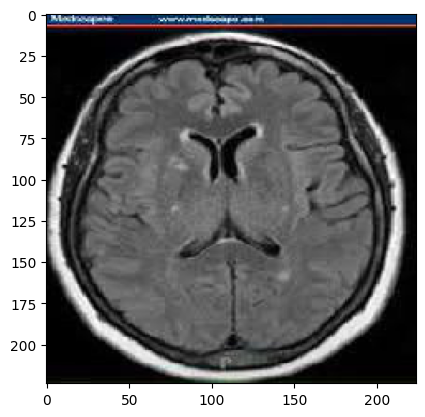

In [ ]:
plt.imshow(data_for_testing[3])

### Conversion of the labels and data to numpy arrays 

In [ ]:
def data_label_conversion(data,labels):
  #data and label conversion to numpy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)
  #one hot label encoding
  lblenc = LabelEncoder()
  labels = lblenc.fit_transform(labels)
  labels_to_index=dict(zip(lblenc.classes_, lblenc.transform(lblenc.classes_)))
  labels = to_categorical(labels)
  return  data,labels,labels_to_index

### Data insight for Training Data and Testing Data

## Training Data

<Axes: >

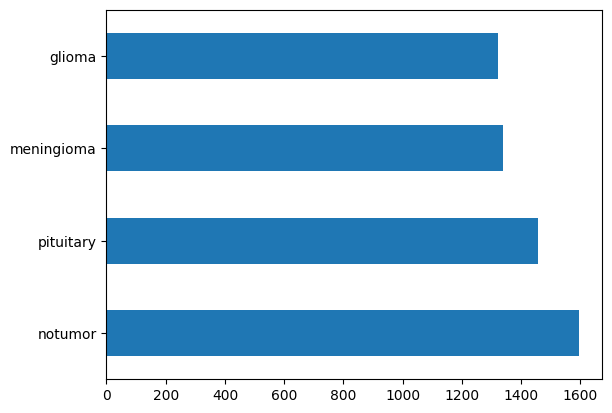

In [ ]:
pd.Series(labels_for_training).value_counts().plot(kind='barh')

## Testing Data

<Axes: >

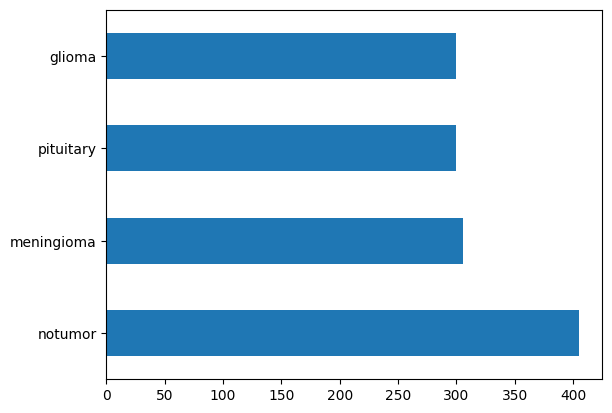

In [ ]:
pd.Series(labels_for_testing).value_counts().plot(kind='barh')

In [ ]:
data_for_training,labels_for_training,labels_to_index = data_label_conversion(data_for_training,labels_for_training)
data_for_testing,labels_for_testing ,_= data_label_conversion(data_for_testing,labels_for_testing)

In [ ]:
print("Train dataset size : ",data_for_training.shape)
print("--------------------------------------")
print("Test dataset size : ",data_for_testing.shape)
print("--------------------------------------")


Train dataset size :  (5712, 224, 224, 3)
--------------------------------------
Test dataset size :  (1311, 224, 224, 3)
--------------------------------------


In [ ]:
#Labels have been converted to numerical values, as shown in the output below.
labels_to_index


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
index_to_labels={}
for label,value in enumerate(labels_to_index):
    index_to_labels[label]=value

### Rescaling and Data Generations

In [ ]:
batch_size=32

#Generations of data and scaling
training_data_generation = ImageDataGenerator(validation_split=0.25)
testing_data_generation = ImageDataGenerator()

training_generation = training_data_generation.flow(data_for_training, labels_for_training, batch_size=batch_size,subset="training")
validation_generation = training_data_generation.flow(data_for_training, labels_for_training, batch_size=batch_size,subset="validation")
testing_generation = testing_data_generation.flow(data_for_testing, labels_for_testing, batch_size=batch_size)

In [ ]:
labels_for_training[3]


array([0., 1., 0., 0.], dtype=float32)

##RESNet50 Initialization

In [ ]:
model_resnet50 = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)
for layer in model_resnet50.layers[:171]:
    layer.trainable = False

for layer in model_resnet50.layers[171:]:
    layer.trainable = True

## Execution of Resnet50 to our dataset

In [ ]:
model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(model_resnet50)
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 36,433,412
Trainable params: 13,900,420
No

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy','AUC'])

# Execution of model for 15 epocs

In [ ]:
history=model.fit(training_generation, 
          epochs=15,
          validation_data=validation_generation
         )

Epoch 1/15
134/134 [==============================] - 40s 167ms/step - loss: 0.8366 - accuracy: 0.6802 - auc: 0.8861 - val_loss: 0.9601 - val_accuracy: 0.6653 - val_auc: 0.8423
Epoch 2/15
134/134 [==============================] - 20s 146ms/step - loss: 0.5800 - accuracy: 0.7647 - auc: 0.9410 - val_loss: 0.5828 - val_accuracy: 0.8046 - val_auc: 0.9581
Epoch 3/15
134/134 [==============================] - 20s 148ms/step - loss: 0.5196 - accuracy: 0.7841 - auc: 0.9518 - val_loss: 0.4426 - val_accuracy: 0.8389 - val_auc: 0.9705
Epoch 4/15
134/134 [==============================] - 20s 150ms/step - loss: 0.4478 - accuracy: 0.8170 - auc: 0.9639 - val_loss: 0.4322 - val_accuracy: 0.8235 - val_auc: 0.9676
Epoch 5/15
134/134 [==============================] - 20s 152ms/step - loss: 0.4354 - accuracy: 0.8268 - auc: 0.9658 - val_loss: 0.4079 - val_accuracy: 0.8396 - val_auc: 0.9699
Epoch 6/15
134/134 [==============================] - 21s 156ms/step - loss: 0.4010 - accuracy: 0.8382 - auc: 0.970

In [ ]:
!mkdir -p saved_model
model.save('saved_model/ResNet50ForBrain')

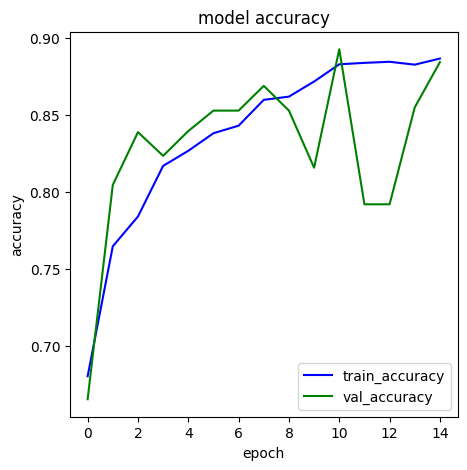

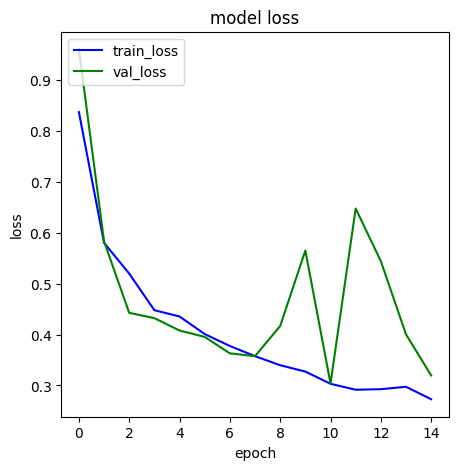

In [ ]:
plt.figure(figsize=(5,5))
hist=history.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(hist['loss'],color="b",label="train_loss")
plt.plot(hist['val_loss'],color="g",label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

## Evaluation of model

In [ ]:
model.evaluate(training_generation)


134/134 [==============================] - 16s 114ms/step - loss: 0.2123 - accuracy: 0.9206 - auc: 0.9921


[0.2123422920703888, 0.920634925365448, 0.9920575022697449]

In [ ]:
model.evaluate(validation_generation)


45/45 [==============================] - 5s 112ms/step - loss: 0.3197 - accuracy: 0.8845 - auc: 0.9818


[0.3196631669998169, 0.8844537734985352, 0.9817672371864319]

In [ ]:
model.evaluate(testing_generation)


41/41 [==============================] - 6s 151ms/step - loss: 0.3405 - accuracy: 0.8635 - auc: 0.9782


[0.3404844105243683, 0.8634629845619202, 0.9781801700592041]

In [ ]:
testing_prediction = model.predict(testing_generation)


41/41 [==============================] - 6s 112ms/step


In [ ]:
testing_prediction


array([[2.6831549e-01, 7.2701001e-01, 1.9207840e-03, 2.7537309e-03],
       [9.6096926e-09, 1.3816761e-05, 9.9998617e-01, 5.5649108e-09],
       [4.4497759e-07, 7.6072522e-02, 7.4170186e-04, 9.2318529e-01],
       ...,
       [3.1496461e-02, 9.5081294e-01, 6.9550816e-03, 1.0735424e-02],
       [9.1720663e-05, 8.6746848e-05, 9.9982041e-01, 1.2485411e-06],
       [1.8357817e-07, 2.2906015e-02, 1.6144768e-04, 9.7693241e-01]],
      dtype=float32)

In [ ]:
test_pred_class=[]
test_labels_class=[]
for i,pred in enumerate(testing_prediction):
    test_pred_class.append(np.int(np.argmax(pred)))
    
for i,pred in enumerate(labels_for_testing):
    test_labels_class.append(np.int(np.argmax(pred)))

In [ ]:
labels=list(index_to_labels.values())
labels

['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
cm = confusion_matrix(test_labels_class, test_pred_class)


In [ ]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized")
    else:
        print('Without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


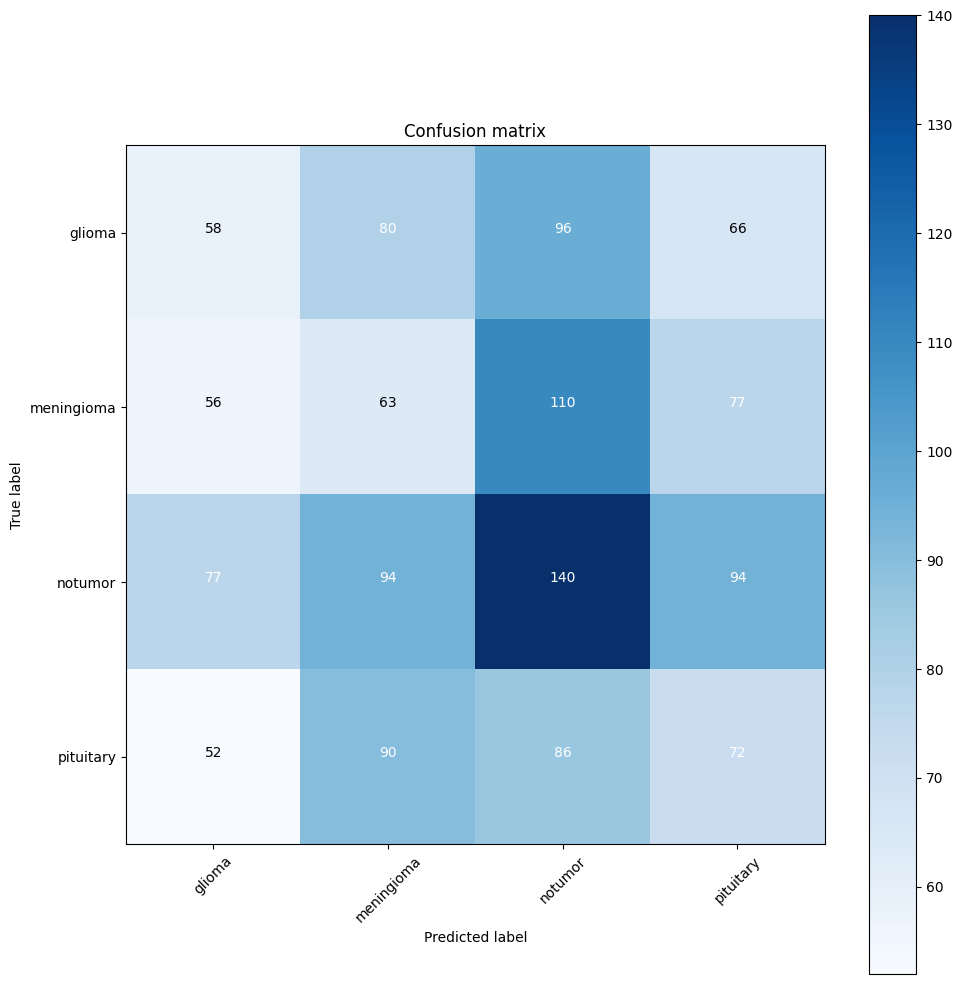

In [ ]:
plot_confusion_matrix(cm,labels)


In [ ]:
AUC=roc_auc_score(labels_for_testing,testing_prediction)
AUC

0.5091334367519806

In [ ]:
path_to_label={}
for i,path in enumerate(testing_paths):
    label = path.split(os.path.sep)[-2]
    path_to_label[path]=label

In [ ]:
predictions=model.predict(testing_generation)


41/41 [==============================] - 4s 105ms/step


In [ ]:
from PIL import Image


1/1 [==============================] - 0s 30ms/step


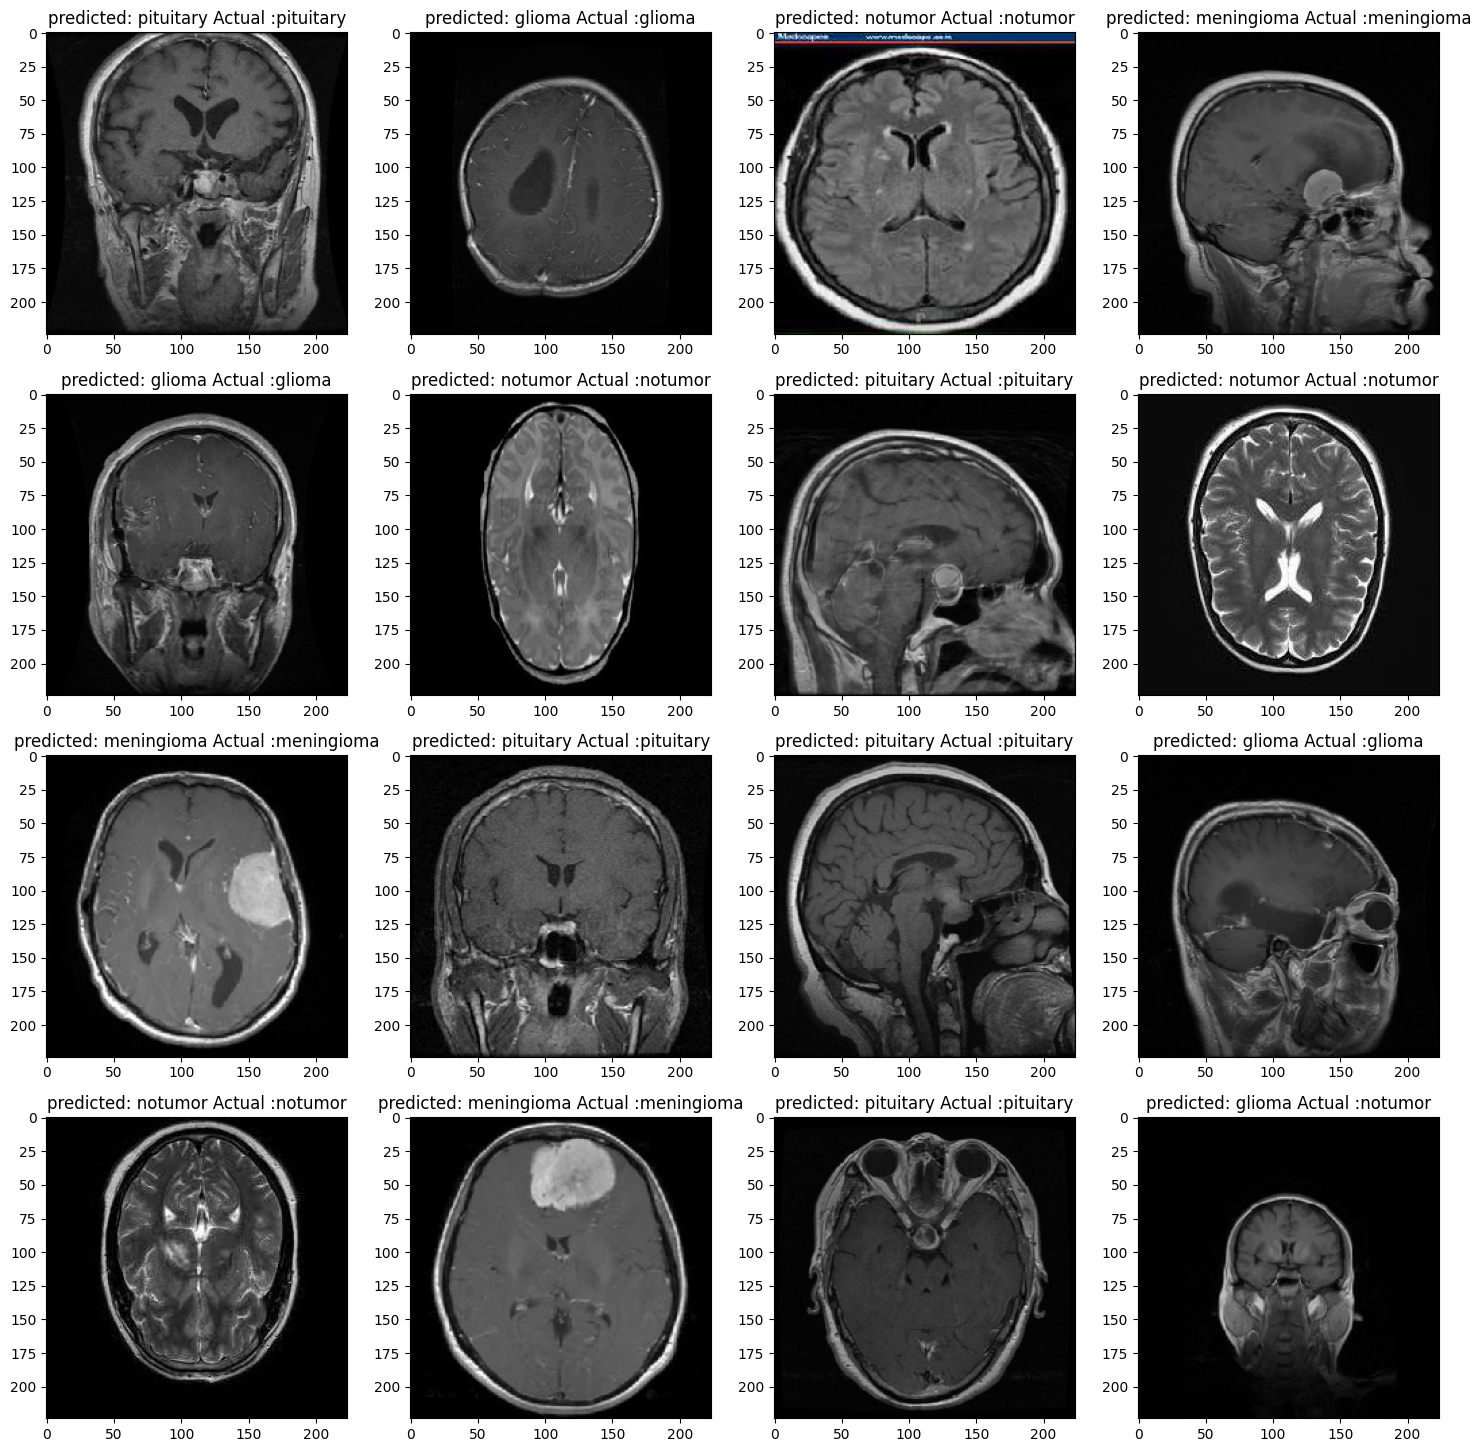

In [ ]:
fig = plt.figure(figsize=(18, 18))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = load_img(testing_paths[i], target_size=(224, 224))
    img = img_to_array(img)
    img = np.array(img)/255.0
    img=np.reshape(img,(-1,224,224,3))
    pred=model.predict(img)
    index=np.argmax(pred)
    klass=index_to_labels[index] 
    actual=path_to_label[testing_paths[i]]
    img=np.reshape(img,(224,224,3))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'predicted: { klass} Actual :{actual}')
plt.show()